### Problem Description

sentimental analysis on Amazon Food Review dataset

dataset link:https://www.kaggle.com/snap/amazon-fine-food-reviews?select=Reviews.csv

### Import Packages

In [1]:
# Add environment Packages paths to conda
import os, sys
# env_name = "food_review"
# sys.path.append(f"C:\\Environments\\{env_name}\\lib\\site-packages\\")

import pandas as pd
import numpy as np

# Text preprocessing packages
import nltk # Text libarary
# nltk.download('stopwords')
import string # Removing special characters {#, @, ...}
import re # Regex Package
from nltk.corpus import stopwords # Stopwords
from nltk.stem import SnowballStemmer, WordNetLemmatizer # Stemmer & Lemmatizer
!python -m pip install -U gensim
from gensim.utils import simple_preprocess  # Text ==> List of Tokens

# Text Embedding
from sklearn.feature_extraction.text import TfidfVectorizer

# Modelling
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score

# Saving Model
import pickle

# Visualization Packages
import seaborn as sns
import matplotlib.pyplot as plt
sns.set(font_scale=1.3)
%matplotlib inline

C:\Users\hp\anaconda3\lib\site-packages\gensim\similarities\__init__.py:15: UserWarning: The gensim.similarities.levenshtein submodule is disabled, because the optional Levenshtein package <https://pypi.org/project/python-Levenshtein/> is unavailable. Install Levenhstein (e.g. `pip install python-Levenshtein`) to suppress this warning.
  warnings.warn(msg)


### Read Dataset

In [2]:
%%time
df = pd.read_csv('Reviews.csv')

Wall time: 7.29 s


In [3]:
f"{df.shape[0]:,} Review"

'568,454 Review'

In [4]:
cols = ['Text', 'Score']
df_text = df[cols].copy()
df_text.head()

,Text,Score
0,I have bought several of the Vitality canned d...,5
1,Product arrived labeled as Jumbo Salted Peanut...,1
2,This is a confection that has been around a fe...,4
3,If you are looking for the secret ingredient i...,2
4,Great taffy at a great price. There was a wid...,5


### Drop Duplicates
Save the Cleaned data-frame also with the variable `df_text`

In [5]:
df_text = df_text.drop_duplicates()

In [6]:
df_text = df_text.reset_index(drop=True)

In [7]:
df_text.duplicated().sum()

0

In [8]:
df_text.head()

,Text,Score
0,I have bought several of the Vitality canned d...,5
1,Product arrived labeled as Jumbo Salted Peanut...,1
2,This is a confection that has been around a fe...,4
3,If you are looking for the secret ingredient i...,2
4,Great taffy at a great price. There was a wid...,5


### Target Variable Pre-Processing
`target` will be 
 - 0 if score < 3 
 - 1 otherwise

In [9]:
df_text['Target'] = df_text['Score'].apply(lambda x: 0 if x < 3 else 1)

In [10]:
df_text['Target'].value_counts()

1    336591
0     57084
Name: Target, dtype: int64

#### Plot Countplot for target Variable

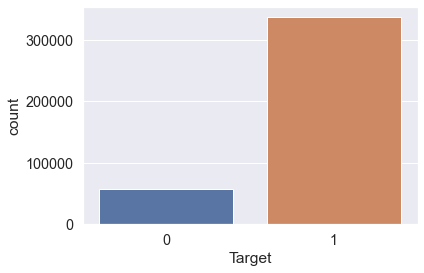

In [11]:
## Write your code here
ax = sns.countplot(x ="Target", data = df_text)

Notice how such variance is huge ...   
Then we need to down-sample such data ... by which both the positive and negative classes are balanced.

### Balance Data Target

In [12]:
# Sample from positive reviews Same number of negative reviews
NEG_N = df_text.Target.value_counts()[0]
df_pos = df_text[df_text['Target'] == 1]['Text'].sample(NEG_N, replace=False)
df_text_balanced = pd.concat([df_text.iloc[df_pos.index], df_text[df_text.Target == 0]], ignore_index = True)

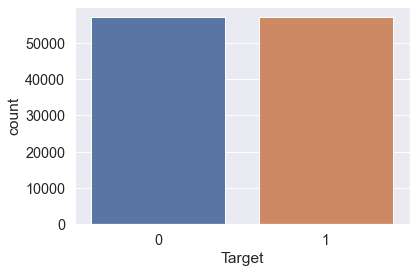

In [13]:
ax = sns.countplot(x ="Target", data = df_text_balanced)

### Text Pre-Processing

In [14]:
import nltk
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\hp\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [15]:
stop_words = set(stopwords.words('english'))
stemmer = SnowballStemmer("english")
lemmatizer= WordNetLemmatizer()

In [16]:
df_text_balanced['Text']

0         My wife can't go a day without her Chai, simpl...
1         My daughter in law brought out Old Bay to seas...
2         I suppose I prefer this product over the truff...
3         These are tasty, different and very original s...
4         When I first bit into this chocolate-wrapped p...
                                ...                        
114163    I just bought this soup today at my local groc...
114164    This soup is mostly broth. Although it has a k...
114165    It is mostly broth, with the advertised 3/4 cu...
114166    I had ordered some of these a few months back ...
114167    I'm disappointed with the flavor. The chocolat...
Name: Text, Length: 114168, dtype: object

In [17]:
df_text_balanced['Text'] = df_text_balanced['Text'].apply(lambda x:  ' '.join([item for item in x.split() if item not in stop_words]))

In [18]:
df_text_balanced['Text']

0         My wife can't go day without Chai, simply love...
1         My daughter law brought Old Bay season hash br...
2         I suppose I prefer product truffles platinum b...
3         These tasty, different original snacks. The to...
4         When I first bit chocolate-wrapped peanut butt...
                                ...                        
114163    I bought soup today local grocer, brought back...
114164    This soup mostly broth. Although kick it, also...
114165    It mostly broth, advertised 3/4 cup vegetables...
114166    I ordered months back great, latest batch terr...
114167    I'm disappointed flavor. The chocolate notes e...
Name: Text, Length: 114168, dtype: object

In [19]:
#nltk.download('wordnet')
df_text_balanced['Text'] = df_text_balanced['Text'].apply(lambda x: lemmatizer.lemmatize(x))

In [20]:
df_text_balanced['Text']

0         My wife can't go day without Chai, simply love...
1         My daughter law brought Old Bay season hash br...
2         I suppose I prefer product truffles platinum b...
3         These tasty, different original snacks. The to...
4         When I first bit chocolate-wrapped peanut butt...
                                ...                        
114163    I bought soup today local grocer, brought back...
114164    This soup mostly broth. Although kick it, also...
114165    It mostly broth, advertised 3/4 cup vegetables...
114166    I ordered months back great, latest batch terr...
114167    I'm disappointed flavor. The chocolate notes e...
Name: Text, Length: 114168, dtype: object

In [21]:
df_text_balanced['Text'] = df_text_balanced['Text'].apply(lambda x: stemmer.stem(x))

In [22]:
df_text_balanced['Text']

0         my wife can't go day without chai, simply love...
1         my daughter law brought old bay season hash br...
2         i suppose i prefer product truffles platinum b...
3         these tasty, different original snacks. the to...
4         when i first bit chocolate-wrapped peanut butt...
                                ...                        
114163    i bought soup today local grocer, brought back...
114164    this soup mostly broth. although kick it, also...
114165    it mostly broth, advertised 3/4 cup vegetables...
114166    i ordered months back great, latest batch terr...
114167    i'm disappointed flavor. the chocolate notes e...
Name: Text, Length: 114168, dtype: object

### Split Test & Training Data

In [23]:
df_text_balanced.head()

,Text,Score,Target
0,"my wife can't go day without chai, simply love...",5,1
1,my daughter law brought old bay season hash br...,5,1
2,i suppose i prefer product truffles platinum b...,5,1
3,"these tasty, different original snacks. the to...",5,1
4,when i first bit chocolate-wrapped peanut butt...,5,1


In [24]:
from sklearn.model_selection import train_test_split
X = df_text_balanced['Text']
y = df_text_balanced['Target']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

In [25]:
X_train.shape

(79917,)

### Text Embedding
 - Use `TfidfVectorizer`
 - `fit` on the training data only
 - `transform` on training and test 

In [26]:
from sklearn.feature_extraction.text import TfidfVectorizer
vectorizer = TfidfVectorizer()

# fit on training (such vectorizer will be saved for deployment)
vectorizer_tfidf = vectorizer.fit(X_train)

# transform on training data
X_train = vectorizer.transform(X_train)

# transform on testing data
X_test = vectorizer.transform(X_test)

In [27]:
# See the dimensions of your data embeddings before entering to the model
X_train.shape, X_test.shape

((79917, 56780), (34251, 56780))

### Modelling

In [28]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score

##### Sklearn framework steps
 - init
 - fit
 - predict

In [29]:
## initialize your Model
clf = RandomForestClassifier()
# Fit your Model on the Training Dataset
clf.fit(X_train, y_train)
# Predict on Test data
preds = clf.predict(X_test)
# Calculate Model Accuracy
acc = accuracy_score(preds, y_test)
print(f"Model Accuracy = {round(acc*100,2)}%")

Model Accuracy = 84.47%


## Clean Review 

In [30]:
#nltk.download('punkt')

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\hp\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

In [31]:
def clean(review):
    review = ' '.join([word for word in review.split() if word not in (stop_words)])
    review = ' '.join([stemmer.stem(word) for word in review.split()])
    review = ' '.join([lemmatizer.lemmatize(word) for word in review.split()])
    return review

### Raw Instance Prediction

In [32]:
def raw_test(review, model, vectorizer):
    # Clean Review
    review_c = clean(review)
    # Embed review using tf-idf vectorizer
    embedding = vectorizer.transform([review_c])
    # Predict using your model
    prediction = model.predict(embedding)
    # Return the Sentiment Prediction
    return "Positive" if prediction == 1 else "Negative"

In [33]:
review_1 = "That's a good Dish, Good Job"
review_2 = "That's the worst Dish ever tasted"

In [34]:
raw_test(review_1, clf, vectorizer_tfidf)

'Positive'

In [35]:
raw_test(review_2, clf, vectorizer_tfidf)

'Negative'

### Saving Models for Deployment

In [36]:
import pickle

In [37]:
model_name = 'rf_model.pk'
vectorizer_name = 'tfidf_vectorizer.pk'
model_path = os.path.join('/', model_name)
vect_path = os.path.join('/', vectorizer_name)

## Save model
with open('rf_model.pk', 'wb') as f1:
    pickle.dump(clf, f1)
    
    
## Save tfidf-vectorizer
with open('tfidf_vectorizer.pk', 'wb') as f2:
    pickle.dump(vectorizer, f2)

### Load model Again and test them

In [38]:
loaded_model =pickle.load(open(model_name, 'rb'))
loaded_vect = pickle.load(open(vectorizer_name, 'rb'))

In [39]:
raw_test(review_1, loaded_model, loaded_vect)

'Positive'

In [40]:
raw_test(review_2, loaded_model, loaded_vect)

'Negative'

# Great Job !
### Now Deploy your ML model using Streamlit Framework

In [41]:
import streamlit

In [ ]:
!streamlit run deployment.py